In [1]:
import copy
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn3
from tqdm import tqdm

from vnc_networks import MANC, UID, CMatrix, Connections, params
from vnc_networks.utils import plots_design

In [2]:
# ----- Directories
manc_version = "v1.2"
MDN_DIR = "sensory_to_mns"
FIG_DIR = MANC(manc_version).get_fig_dir()
MDN_FIGS = os.path.join(FIG_DIR, MDN_DIR)
os.makedirs(MDN_FIGS, exist_ok=True)


In [3]:
savefigs = True  # True to save figures

In [4]:
CR = MANC(manc_version)
vanilla_vnc = Connections(CR=CR)  # no neuron splitting or anything
# Define a new connectome from which connections between motor neurons are removed
mn_bids = vanilla_vnc.get_neuron_bodyids({"class_1": "motor"})
vnc_clean_mns = Connections(CR=CR, not_connected=mn_bids)

Attribute class_1 not found in the graph. Adding it.
Attribute class_1 not found in the graph. Adding it.


# SN to MN connections

## 1 and 2 hop connections

In [5]:
# Input and output populations
motor_neurons = vnc_clean_mns.get_neuron_ids(
    {
        "class_1": "motor", # Will also give wing etc motor neurons
    }
)
sensory_neurons = vnc_clean_mns.get_neuron_ids(
    {
        "class_1": "sensory",
    }
)
ascending_sensory = vnc_clean_mns.get_neuron_ids(
    {
        "class_1": "sensory_ascending",
    }
)
sensory_neurons = sensory_neurons + ascending_sensory
cmat_clean = vnc_clean_mns.get_cmatrix(type_="syn_count") # Faster to do this way

In [6]:
# Connections at + and - 1
post_sn_neurons = cmat_clean.list_downstream_neurons(sensory_neurons)
pre_mn_neurons = cmat_clean.list_upstream_neurons(motor_neurons)

In [7]:
# Identify premotor neurons
print(
    f"Found {len(sensory_neurons)} sensory neurons and {len(post_sn_neurons)} neurons directly downstream"
)
print(
    f"Found {len(motor_neurons)} motor neurons and {len(pre_mn_neurons)} premotor neurons"
)
all_nodes = vnc_clean_mns.get_nodes()
print(f"Found {len(all_nodes)} neurons in the VNC")


Found 6425 sensory neurons and 16836 neurons directly downstream
Found 736 motor neurons and 11830 premotor neurons
Found 23543 neurons in the VNC


In [8]:
# How many MNs are within 2 hops of DNs?
cmat_clean.power_n(2)

In [9]:
sn_mns = cmat_clean.list_downstream_neurons(sensory_neurons)
sn_mns = [n for n in sn_mns if n in motor_neurons]
print(
    f"Found {len(sn_mns)} out of {len(motor_neurons)} motor neurons downstream of SNs in 2 hops"
)


Found 734 out of 736 motor neurons downstream of SNs in 2 hops


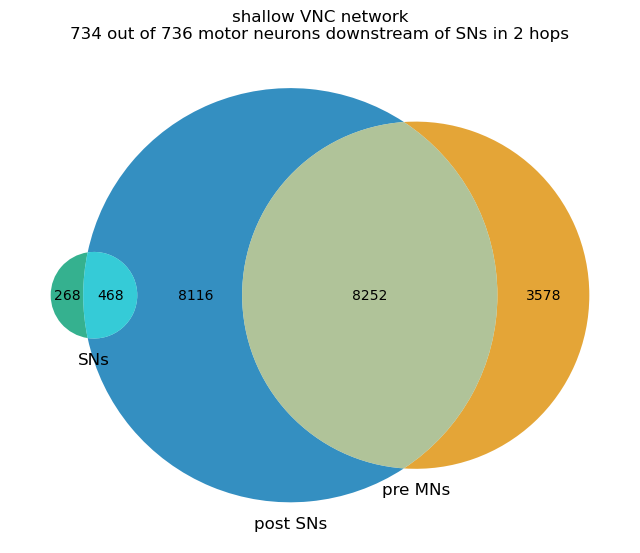

In [10]:
fig, ax = plt.subplots(1, 1, figsize=params.FIGSIZE)

colors = params.custom_palette[:3]
v = venn3(
    [set(post_sn_neurons), set(motor_neurons), set(pre_mn_neurons)],
    ("post SNs","SNs", 'pre MNs'),
    ax=ax,
    set_colors=colors,
    alpha=0.8,
)
ax.set_title(
    "shallow VNC network" + '\n'
    + f"{len(sn_mns)} out of {len(motor_neurons)} motor neurons downstream of SNs in 2 hops"
    )

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "venn_diagram_premotor_neurons_vs_post-sns.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )


## Dependency on synapse thresholding

In [11]:
def ratio_intersection(
    vnc_: Connections,
    motor_neurons_: list[UID],
    descending_neurons_: list[UID],
    threshold: int = 0,
):
    """
    Look at the intersection between [motor_neurons, pre_mn_neurons] and [post_dn_neurons]
    in terms of existing connections, as a function of the synapse threshold
    use to define a valid connection.
    Compute the ratio of the intersection to size of the minimal set (theoretically 1
    if the two sets are included in each other).
    This allows to quantify how much the DNs can talk directly or within 2 hops to the MNs.

    ! Warning: the numebr of premotor and post-dn neuron changes with the threshold
    as well, they are not fixed populations.
    """
    df_ = copy.deepcopy(vnc_.get_dataframe())

    # Remove all the entries with 'syn_count' < threshold
    df_ = df_[df_["syn_count"] >= threshold]

    # Identify the premotor neurons and the post-dn neurons
    premotor_neurons_ = np.unique(
        df_[df_["end_uid"].isin(motor_neurons_)]["start_uid"].values
    )
    mn_and_premnms_ = set(premotor_neurons_) | set(motor_neurons_)
    post_dn_neurons_ = np.unique(
        df_[df_["start_uid"].isin(descending_neurons_)]["end_uid"].values
    )

    # Maximum number of neurons in the smallest set:
    total_pool_ = min(len(post_dn_neurons_), len(mn_and_premnms_))
    if total_pool_ == 0:
        return np.nan, 0

    # Intersection of interest
    pre_and_post_ = set(mn_and_premnms_) & set(post_dn_neurons_)

    # Ratio of the intersection to the size of the smallest set
    ratio_ = len(pre_and_post_) / total_pool_

    return ratio_, total_pool_


In [12]:
theta = np.arange(0, 380, 1)
ratios = np.zeros(len(theta))
pool_size = np.zeros(len(theta))
for i, t in enumerate(theta):
    ratios[i], pool_size[i] = ratio_intersection(
        vnc_clean_mns,
        motor_neurons_=motor_neurons,
        descending_neurons_=sensory_neurons,
        threshold=t,
    )



In [13]:
# WARNING: this is veeeeery slow
# For each random seed and each theta value, it needs to resample
# the entire connectome and find connectivity intersections

nb_random = 100
rand_pool_size = np.zeros((nb_random, len(theta)))
rand_ratios = np.zeros((nb_random, len(theta)))

for i in tqdm(range(nb_random)):
    random_inputs = np.random.choice(
        all_nodes, len(sensory_neurons), replace=False
    )
    random_outputs = np.random.choice(
        all_nodes, len(motor_neurons), replace=False
    )
    rand_ratios[i, :] = np.zeros(len(theta))
    rand_pool_size[i, :] = np.zeros(len(theta))
    for j, t in enumerate(theta):
        rand_ratios[i, j], rand_pool_size[i, j] = ratio_intersection(
            vnc_clean_mns,
            motor_neurons_=random_outputs,
            descending_neurons_=random_inputs,
            threshold=t,
        )

100%|██████████| 100/100 [42:26<00:00, 25.47s/it]


In [16]:
mean_rand = np.mean(rand_ratios, axis=0)
std_rand = np.std(rand_ratios, axis=0)

print("Comparison with random neuron pools of the same size:")
for t in [5, 10, 40 , 100]:
    print(f"theshold {t}: {100*mean_rand[t]:.2f}% overlap")

if savefigs:
    stats_file = os.path.join(MDN_FIGS, "stats.txt")
    with open(stats_file, "w") as f:
        f.write(f"Comparison with {nb_random} random neuron pools of the same size:\n")
        for t in [5, 10, 40 , 100]:
            f.write(f"theshold {t}: {100*mean_rand[t]:.2f}% overlap\n")

Comparison with random neuron pools of the same size:
theshold 5: 94.33% overlap
theshold 10: 87.24% overlap
theshold 40: 59.86% overlap
theshold 100: 28.30% overlap


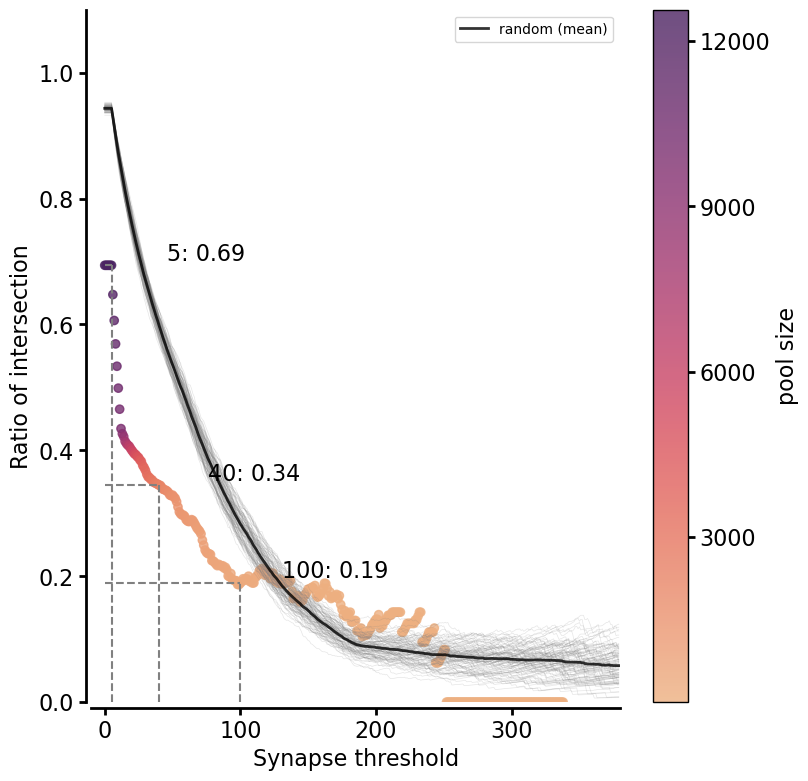

In [21]:
fig, ax = plt.subplots(1, 1, figsize=params.FIGSIZE)

for i in range(nb_random): # Random single traces as thin grey lines
    ax.plot(
        rand_ratios[i, :],
        c="grey",
        linewidth=0.5,
        alpha=0.2,
    )

# Plot the mean and the std of the random traces as a thick grey line and shaded area
ax.plot(
    mean_rand,
    c="k",
    linewidth=2,
    alpha=0.8,
    label="random (mean)",
)

ax = plots_design.scatter_xyz_2d(
    X=theta,
    Y=ratios,
    Z=pool_size,
    ax=ax,
    cmap=params.red_colorscale,
    z_label="pool size",
)
ax.set_ylim([0, 1.1])
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_xlim([-10, 380])
ax.set_xticks(np.arange(0, 380, 100))
ax.set_xlabel("Synapse threshold")
ax.set_ylabel("Ratio of intersection")

# highlight a few notable points
highlights = [5, 40, 100]
for h in highlights:
    ax.vlines(
        x=h,
        ymin=0,
        ymax=ratios[h],
        color="grey",
        linestyle="--",
    )
    ax.hlines(
        y=ratios[h],
        xmin=0,
        xmax=h,
        color="grey",
        linestyle="--",
    )
    ax.text(
        x=h + 70,
        y=ratios[h],
        s=f"{h}: {ratios[h]:.2f}",
        fontsize=params.LABEL_SIZE,
        ha="center",
        va="bottom",
    )
ax.legend()

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "ratio_intersection_premotor_neurons_vs_post-sns_fnctn_syn_threshold_baseline.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
        transparent=True,
    )
plt.show()


# Graph layering

## Histogram of layer sizes
We work with the vanilla VNC, except that connecitons between motor neurons are ignored to be really considered as the output layer.

In [ ]:
clean_cmat = vnc_clean_mns.get_cmatrix(type_="unnorm")

assigned_neurons = []
# For descending neurons, define an attribute "graph_layer" equal to 0
layer_dict = {}
layer_size = {}
for n in sensory_neurons:
    layer_dict[n] = 0
layer_size[0] = len(sensory_neurons)

assigned_neurons = assigned_neurons + sensory_neurons
current_layer_neurons = sensory_neurons
current_layer = 0
# Assign layers as long as not all neurons are assigned
total_neurons = len(vnc_clean_mns.get_nodes())
while len(assigned_neurons) < total_neurons:

    # Identify all the neurons that are downstream of the current layer
    layer_neurons = clean_cmat.list_downstream_neurons(current_layer_neurons)
    layer_neurons = [n for n in layer_neurons if n not in assigned_neurons]
    
    assigned_neurons = assigned_neurons + layer_neurons
    current_layer_neurons = layer_neurons

    if isinstance(layer_neurons, int): # len == 1 with automatic transformation
        print("Only one neuron to assign, left with: ", total_neurons - len(assigned_neurons), "neurons")
        layer_neurons = [layer_neurons] # keep as a list
    elif layer_neurons == []:
        print("No more neurons to assign, left with: ", total_neurons - len(assigned_neurons), "neurons")
        break

    # Assign them to the next layer
    for n in layer_neurons:
        layer_dict[n] = current_layer + 1
    layer_size[current_layer + 1] = len(layer_neurons)
    
    current_layer += 1

not_assigned = [n for n in all_nodes if n not in assigned_neurons]
for n in not_assigned:
    layer_dict[n] = -1
layer_size[-1] = len(not_assigned)


In [ ]:
def mn_in_layer(
    layer: int,
    layer_dict: dict,
    motor_neurons_: list[UID],
) -> int:
    """
    Count the number of motor neurons in a given layer
    """
    # Get the neurons in the layer
    layer_neurons = [n for n, l in layer_dict.items() if l == layer]
    # Count the number of motor neurons in the layer
    mn_count = len([n for n in layer_neurons if n in motor_neurons_])
    return mn_count

# Draw the layer size distribution
print(layer_size)
layer_size_df = pd.DataFrame.from_dict(layer_size, orient="index")
layer_size_df = layer_size_df.reset_index()
layer_size_df.columns = ["layer", "size"]
layer_size_df = layer_size_df.sort_values(by="layer")
layer_size_df = layer_size_df.reset_index(drop=True)
# Add a column with the nb of motor neurons in each layer
layer_size_df["motor_neurons"] = layer_size_df["layer"].apply(
    lambda x: mn_in_layer(x, layer_dict, motor_neurons)
)
layer_size_df["sensory_neurons"] = 0
layer_size_df.loc[layer_size_df["layer"] == 0, "sensory_neurons"] = layer_size_df[
    "size"
]
# Draw 
layer_size_df["rest_neurons"] = (
    layer_size_df["size"]
    - layer_size_df["motor_neurons"]
    - layer_size_df["sensory_neurons"]
)
fig, ax = plt.subplots(1, 1, figsize=params.FIGSIZE)
ax.bar(
    layer_size_df["layer"],
    layer_size_df["size"],
    bottom=layer_size_df["motor_neurons"],
    label="Other VNC neurons",
    color=params.DARKGREY,
)
ax.bar(
    layer_size_df["layer"],
    layer_size_df["sensory_neurons"],
    label="Sensory neurons",
    color=params.DARKBLUE,
)
ax.bar(
    layer_size_df["layer"],
    layer_size_df["motor_neurons"],
    label="Motor neurons",
    color=params.LIGHTBLUE,
)
ax.set_xlabel("Layer")
ax.set_ylabel("Number of neurons")
ax.set_title("Layer size distribution")
ax.legend()
plots_design.make_nice_spines(ax)
#ax.set_yticks([0, 5000, 10000, 15000])
#ax.set_yticklabels([0, 5000, 10000, 15000])
ax.set_xticks(layer_size_df["layer"])
ax.set_xticklabels(layer_size_df["layer"])
if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "layer_size_distribution_from_sns.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )
plt.show()


In [ ]:
if savefigs:
    # Save the layer_dict as a dataframe to csv
    layer_dict_df = pd.DataFrame.from_dict(layer_dict, orient="index")
    layer_dict_df = layer_dict_df.reset_index()
    layer_dict_df.columns = ["uid", "layer"]
    layer_dict_df["body_id"] = layer_dict_df["uid"].apply(
        lambda x: vanilla_vnc.get_bodyids_from_uids(x)[0]
    )

    # Save the dataframe to csv
    layer_dict_df.to_csv(
        os.path.join(MDN_FIGS, "layer_dict_from_sns.csv"),
        index=False,
    )

## Per-MN input from layers

### Unweighted (nb connections)

In [ ]:
# layer_dict has the layer assignment for each neuron
def layer_input_to_mn(
    mn_: UID,  # which target
    layer_dict_: dict,  # info about the layers
    cmat: CMatrix,  # connectivity matrix
    weighted: bool = False,  # use weighted connections
    threshold: int = params.SYNAPSE_CUTOFF,  # synapse threshold
) -> float:
    """
    Compute the layer-weighted direct input to a given motor neuron
    """
    # Threshold the connections
    cmat_ = copy.deepcopy(cmat)
    if threshold > params.SYNAPSE_CUTOFF:
        cmat_.threshold(threshold)

    # Get the neurons upstream of the motor neuron
    upstream_neurons_ = cmat_.list_upstream_neurons([mn_])

    # Sum the contributions from each layer
    layer_contributions = 0
    total_weights = 0
        
    for n in upstream_neurons_:
        try:
            layer = layer_dict_[n]
        except KeyError:
            # If the neuron is not in the layer_dict, it is a sensory neuron
            # and should be ignored
            continue
        if layer == -1:
            # If the neuron is not assigned to a layer, ignore it
            continue
        weight = np.abs(cmat_.get_mat_entry(n, mn_))
        assert weight >= 0, f"This should not be an entry"
        if weighted:
            layer_contributions +=weight*layer
            total_weights += weight
        else:
            layer_contributions += layer
            total_weights += 1 # count the number of connections with an assigned layer

    # Normalize by the number of upstream neurons
    layer_contributions /= total_weights
    
    return layer_contributions



In [ ]:
unweighted_contributions = []
weighted_contributions = []
for mn_ in motor_neurons:
    unweighted_contributions.append(
        layer_input_to_mn(
            mn_,
            layer_dict,
            cmat=clean_cmat,
            weighted=False,
        )
    )
    weighted_contributions.append(
        layer_input_to_mn(
            mn_,
            layer_dict,
            cmat=clean_cmat,
            weighted=True,
        )
    )

In [ ]:

# Plot the results as a violin plot
fig, ax = plt.subplots(1, 1, figsize=params.FIGSIZE)
sns.violinplot(
    data=[unweighted_contributions, weighted_contributions],
    ax=ax,
    palette=params.custom_palette[:2],
    bw_method=0.3,
    split=True,
    inner="quart",
    fill=False,
)
ax.set_ylabel("Layer input to motor neurons")
ax.set_xlabel("Input type")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Unweighted", "Weighted"])
ax.set_yticks([0, 1, 2])
ax.set_yticklabels([0, 1, 2])
ax.set_title("Layer input to motor neurons")

# add labels with the mean values
mean_unweighted = np.mean(unweighted_contributions)
mean_weighted = np.mean(weighted_contributions)
ax.text(
    x=0,
    y=mean_unweighted + 0.5,
    s=f"mean: {mean_unweighted:.2f}",
    fontsize=params.LABEL_SIZE,
    ha="center",
    va="bottom",
)
ax.text(
    x=1,
    y=mean_weighted + 0.5,
    s=f"mean: {mean_weighted:.2f}",
    fontsize=params.LABEL_SIZE,
    ha="center",
    va="bottom",
)

plots_design.make_nice_spines(ax)

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "layer_from_sns_input_to_motor_neurons_violin.pdf"),
        dpi=params.DPI,
        bbox_inches="tight",
    )

plt.show()